<a href="https://colab.research.google.com/github/priyadharshini13/oxford_ml_project/blob/main/Group3_AI_ML_Assignment_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary packages
%pip install prophet
%pip install scikit-learn
%pip install behave
%pip install pandas
%pip install numpy
%pip install statsmodels
%pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import itertools
# from google.colab import files
import io
from sklearn.model_selection import TimeSeriesSplit
import unittest
import seaborn as sns
import time
from google.colab import files
# import kellys

# data = kellys.load_data()


In [10]:
# Step 1: Upload the CSV file
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Load the dataset
data = pd.read_csv(io.BytesIO(uploaded[filename]))


Saving synthetic_retail_data_for_demand_prediction.csv to synthetic_retail_data_for_demand_prediction (1).csv


In [11]:
data.head()

,Date of Sale,Store ID,Country,Product ID,Product Category,Units Sold,Price Sold,GDP Growth Rate,Inflation Rate
0,2000-01-01,4,USA,15,Home & Kitchen,14,229.25,1.716353,1.006865
1,2000-01-02,5,Canada,6,Electronics,21,104.01,1.955608,2.417040
2,2000-01-03,3,Canada,11,Electronics,16,169.17,1.774069,2.509185
3,2000-01-04,5,USA,8,Books,19,179.60,2.112682,2.636036
4,2000-01-05,5,Mexico,17,Books,24,286.81,1.943792,1.945556


In [12]:
# @title Step 4: Split Data into Training and Testing Sets
data['Date of Sale'] = pd.to_datetime(data['Date of Sale'])

# Set the date column as the index
data.set_index('Date of Sale', inplace=True)

# Select the 'Units Sold' column for time series analysis
ts_data = data[['Units Sold']]

# Add additional parameters (e.g., Country, Store ID, Product ID, Product Category)
time_series_data = pd.get_dummies(data[['Country', 'Store ID', 'Product ID', 'Product Category']], drop_first=True)

# Convert boolean columns to integers
bool_columns = time_series_data.select_dtypes(include=['bool']).columns
time_series_data[bool_columns] = time_series_data[bool_columns].astype(int)

# Ensure time_series_data variables are numeric
time_series_data = time_series_data.apply(pd.to_numeric, errors='coerce')

# Check the data types of the time_series_data variables
print("time_series_data variables data types after conversion:\n", time_series_data.dtypes)

# Split the data into training and testing sets
split_point = int(len(ts_data) * 0.8)
train_data, test_data = ts_data[:split_point], ts_data[split_point:]
train_ts, test_ts = time_series_data[:split_point], time_series_data[split_point:]

# Ensure the data is numeric
train_data = train_data.astype(float)
test_data = test_data.astype(float)

print(f"Training data: {len(train_data)} records")
print(f"Testing data: {len(test_data)} records")
print(f"Training time_series_data data types:\n{train_ts.dtypes}")

# Ensure no non-numeric columns remain
non_numeric_columns = train_ts.select_dtypes(exclude=['number']).columns
if len(non_numeric_columns) > 0:
    raise ValueError(f"Non-numeric columns in training exogenous data: {non_numeric_columns}")
else:
    print("All training time_series_data data columns are numeric.")

print(f"Training data: {len(train_data)} records")
print(f"Testing data: {len(test_data)} records")



time_series_data variables data types after conversion:
 Store ID                           int64
Product ID                         int64
Country_Mexico                     int64
Country_USA                        int64
Product Category_Clothing          int64
Product Category_Electronics       int64
Product Category_Home & Kitchen    int64
Product Category_Sports            int64
dtype: object
Training data: 7134 records
Testing data: 1784 records
Training time_series_data data types:
Store ID                           int64
Product ID                         int64
Country_Mexico                     int64
Country_USA                        int64
Product Category_Clothing          int64
Product Category_Electronics       int64
Product Category_Home & Kitchen    int64
Product Category_Sports            int64
dtype: object
All training time_series_data data columns are numeric.
Training data: 7134 records
Testing data: 1784 records


In [15]:
sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=train_ts, enforce_stationarity=False, enforce_invertibility=False)

# Fit the model
sarima_results = sarima_model.fit(disp=False)

# Print model summary
print(sarima_results.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                         Units Sold   No. Observations:                 7134
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -21679.497
Date:                            Sun, 16 Jun 2024   AIC                          43384.995
Time:                                    16:33:45   BIC                          43474.290
Sample:                                01-01-2000   HQIC                         43415.741
                                     - 07-13-2019                                         
Covariance Type:                              opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Store ID                           -0.0500      0.042     -1.203      0.

In [18]:
# Make predictions on the testing set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib.dates import DateFormatter, MonthLocator, YearLocator
test_pred = sarima_results.get_forecast(steps=len(test_data), exog=test_ts)
test_pred_mean = test_pred.predicted_mean
test_pred_conf = test_pred.conf_int()

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(test_data, test_pred_mean))
mae = mean_absolute_error(test_data, test_pred_mean)
r2 = r2_score(test_data, test_pred_mean)

print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test R2: {r2}")


Test RMSE: 5.290047823827801
Test MAE: 4.095332522153994
Test R2: -0.003723075434520551


In [21]:
# Define the forecast period
forecast_start = pd.to_datetime('2024-05-01')
forecast_end = pd.to_datetime('2030-05-01')
forecast_steps = (forecast_end.year - forecast_start.year) * 12 + (forecast_end.month - forecast_start.month)

# Make predictions
forecast = sarima_results.get_forecast(steps=forecast_steps, exog=test_ts[:72])
forecast_index = pd.date_range(start=forecast_start, periods=forecast_steps, freq='M')
predicted_means = forecast.predicted_mean
predicted_conf = forecast.conf_int()

# Ensure forecast index matches predicted means
predicted_means.index = forecast_index
predicted_conf.index = forecast_index

# Convert the index to string format
predicted_means.index = predicted_means.index.strftime('%Y-%m-%d')
predicted_conf.index = predicted_conf.index.strftime('%Y-%m-%d')


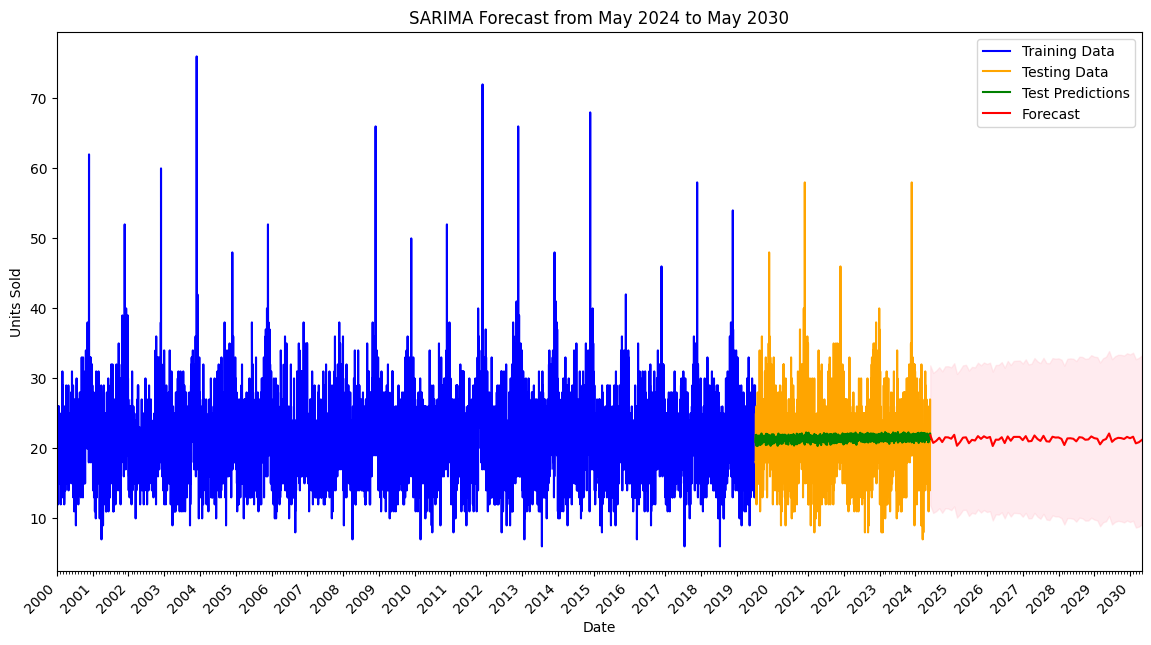

In [22]:
# Convert the x-axis limits to datetime
start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2030-05-01')

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the training data
ax.plot(train_data.index, train_data, label='Training Data', color='blue')

# Plot the testing data and predictions
ax.plot(test_data.index, test_data, label='Testing Data', color='orange')
ax.plot(test_pred_mean.index, test_pred_mean, label='Test Predictions', color='green')

# Plot the forecasted data
ax.plot(pd.to_datetime(predicted_means.index), predicted_means, label='Forecast', color='red')
ax.fill_between(pd.to_datetime(predicted_conf.index), predicted_conf.iloc[:, 0], predicted_conf.iloc[:, 1], color='pink', alpha=0.3)

# Set major and minor locators and formatters
ax.xaxis.set_major_locator(YearLocator(1))  # Set major ticks to every year
ax.xaxis.set_minor_locator(MonthLocator())  # Set minor ticks to every month
ax.xaxis.set_major_formatter(DateFormatter('%Y'))  # Format major ticks to display the year

# Improve the visibility of x-axis labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Explicitly set x-ticks starting from the first year in the data
xticks = pd.date_range(start=start_date, end=end_date, freq='YS')
ax.set_xticks(xticks)

plt.xlim([start_date, end_date])
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('SARIMA Forecast from May 2024 to May 2030')
plt.legend()
plt.show()


In [ ]:
import pandas as pd

def preprocess_future_exog(future_exog):
    # Convert categorical variables into dummy/indicator variables
    future_exog = pd.get_dummies(future_exog, drop_first=True)

    # Convert boolean columns to integers
    bool_columns = future_exog.select_dtypes(include=['bool']).columns
    future_exog[bool_columns] = future_exog[bool_columns].astype(int)

    # Ensure the future_exog has the same columns as train_exog
    future_exog = future_exog.reindex(columns=train_exog.columns, fill_value=0)

    # Ensure all exog variables are numeric
    future_exog = future_exog.apply(pd.to_numeric, errors='coerce')

    # Check the data types of the future exogenous variables
    # print("Future exogenous variables data types after conversion:\n", future_exog.dtypes)

    return future_exog

def forecast(future_dates, future_exog):
    future_exog = preprocess_future_exog(future_exog)
    # Forecast future values
    forecast = sarima_results.get_forecast(steps=len(future_dates), exog=future_exog)
    forecast_mean = forecast.predicted_mean

    # Set the index of the forecast to the future dates
    forecast_mean.index = future_dates

    # Print the forecasted sales
    print(forecast_mean)


In [ ]:
# Define future dates for which we want to forecast
future_dates = pd.date_range(start='2025-01-10', end='2025-01-20', freq='D')

# Create a DataFrame for the future dates with the same structure as the exogenous data
future_exog = pd.DataFrame({
    'Country': ['USA'] * len(future_dates),  # Replace with desired countries
    'Store ID': [4] * len(future_dates),    # Replace with desired store IDs
    'Product ID': [15] * len(future_dates), # Replace with desired product IDs
    'Product Category': ['Home & Kitchen'] * len(future_dates)  # Replace with desired product categories
}, index=future_dates)

forecast(future_dates, future_exog)

2025-01-10    21.421311
2025-01-11    20.817316
2025-01-12    21.327177
2025-01-13    20.992884
2025-01-14    21.133009
2025-01-15    21.247856
2025-01-16    21.119485
2025-01-17    20.991065
2025-01-18    21.249822
2025-01-19    20.557062
2025-01-20    21.028192
Freq: D, Name: predicted_mean, dtype: float64


In [ ]:
# Define future dates for which we want to forecast
future_dates = pd.date_range(start='2025-01-10', end='2025-01-20', freq='D')

# Create a DataFrame for the future dates with the same structure as the exogenous data
future_exog = pd.DataFrame({
    'Country': ['Mexico'] * len(future_dates),  # Replace with desired countries
    'Store ID': [5] * len(future_dates),    # Replace with desired store IDs
    'Product ID': [16] * len(future_dates), # Replace with desired product IDs
    'Product Category': ['Home & Kitchen'] * len(future_dates)  # Replace with desired product categories
}, index=future_dates)

forecast(future_dates, future_exog)

2025-01-10    21.353037
2025-01-11    20.749042
2025-01-12    21.258903
2025-01-13    20.924610
2025-01-14    21.064735
2025-01-15    21.179582
2025-01-16    21.051211
2025-01-17    20.922792
2025-01-18    21.181548
2025-01-19    20.488789
2025-01-20    20.959919
Freq: D, Name: predicted_mean, dtype: float64
